# Training

In [13]:
import re

#library to read and import file from drive
import os

import cv2 as cv

import matplotlib.pyplot as plt

import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf

#### Functions

In [14]:
# Load train images (all without defects)
def train_loader(dir='./', scale=False):
    imgs = []
    for img in os.listdir(dir):
        image = cv.imread((dir + '/' + img), cv.IMREAD_GRAYSCALE)
        if scale:
            image = image.astype('float32') / 255.
        imgs.append(image)
    return imgs

In [19]:
# Load the validation set (all with defects)
def test_loader(dir='./', scale=False):
    imgs = {}
    for img in os.listdir(dir):
        img_num = int(re.findall(r'NOK_(\d+)-', img)[0])
        img_order = int(re.findall(r'NOK_\d+-(\d+)', img)[0])
        image = cv.imread((dir + '/' + img), cv.IMREAD_GRAYSCALE)
        if scale:
            image = image.astype('float32') / 255.
        if img_num in imgs.keys():
            imgs[img_num].append([img_order, image])
        else:
            imgs[img_num] = [[img_order, image]]
    return imgs

In [94]:
def SSIMLoss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred,1.0))

## Data loader

In [48]:
# DA SISTEMARE -- SOLO PER TEST
X_train_NOproblem = train_loader('/problemino', scale=True)
X_train_problem = train_loader('/problemi', scale=True)
#X_anomaly = test_loader('../Data/Prepared/Train/NOK', scale=True)

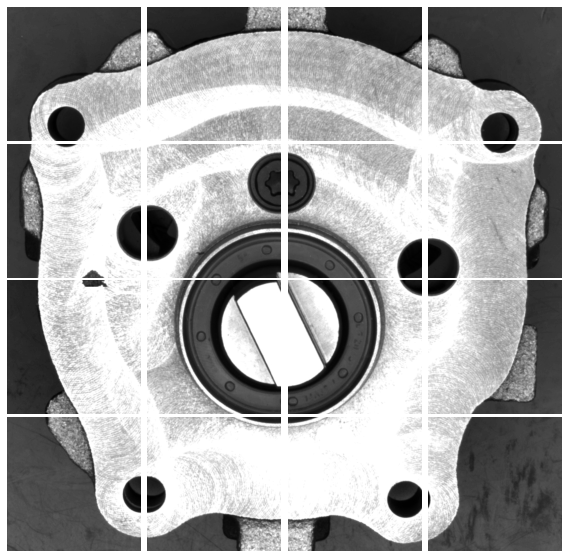

In [ ]:
plt.figure(figsize=(10, 10))
for part in X_anomaly[1]:
    plt.subplot(4, 4, (part[0]+1))
    plt.axis('off')
    plt.subplots_adjust(wspace=0.02, hspace=0.02)
    plt.imshow(part[1], cmap='gray')

## Train e validation set

In [25]:
X_train, X_val = train_test_split(np.expand_dims(np.array(X_train), -1), test_size=0.2, random_state=17)

In [54]:
# DA CANCELLARE -- SOLO PER TEST
X_train_problem = np.expand_dims(np.array(X_train_problem), -1)
X_train_NOproblem = np.expand_dims(np.array(X_train_NOproblem), -1)

# Autoencoder

### Diverse architeture di autoencoder

Autoencoder con convolutional

In [153]:
# Create the Encoder and Decoder

#pass the gray scale input image of size(256,256,1)
inputs = tf.keras.Input(shape=(256, 256, 1), name='input_layer')

# Conv Block 1 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(inputs)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_1')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_1')(encoded)
# Conv Block 2 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_2')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_2')(encoded)
# Conv Block 3 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', name='conv_3')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_3')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_3')(encoded)

#Decoder
# DeConv Block 1-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 1, padding='same',name='conv_transpose_1')(encoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_4')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_4')(decoded)
# DeConv Block 2-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(encoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_5')(encoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_5')(decoded)
# DeConv Block 3-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_3')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_6')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_6')(decoded)

# output
outputs = tf.keras.layers.Conv2DTranspose(1, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(decoded)

Autoencoder con fully connected

In [165]:
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    decoder.add(Reshape(img_shape))

    return encoder, decoder

In [166]:
IMG_SHAPE = X_train_NOproblem.shape[1:]
encoder, decoder = build_autoencoder(IMG_SHAPE, 32)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

print(autoencoder.summary())

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 256, 256, 1)]     0         
                                                                 
 sequential_25 (Sequential)  (None, 32)                2097184   
                                                                 
 sequential_26 (Sequential)  (None, 256, 256, 1)       2162688   
                                                                 
Total params: 4,259,872
Trainable params: 4,259,872
Non-trainable params: 0
_________________________________________________________________
None


### Autoencoder compile e fit

In [163]:
X_train_NOproblem.shape[1:]

(256, 256, 1)

In [167]:
autoencoder.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 256, 256, 1)]     0         
                                                                 
 sequential_25 (Sequential)  (None, 32)                2097184   
                                                                 
 sequential_26 (Sequential)  (None, 256, 256, 1)       2162688   
                                                                 
Total params: 4,259,872
Trainable params: 4,259,872
Non-trainable params: 0
_________________________________________________________________


In [176]:
hist=autoencoder.fit(X_train_problem, X_train_NOproblem, epochs=500, batch_size=10, shuffle=True,
                     validation_split=0.2)

Epoch 1/500
4/4 [==============================] - 0s 20ms/step - loss: 0.0020 - val_loss: 0.0051
Epoch 2/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0021 - val_loss: 0.0053
Epoch 3/500
4/4 [==============================] - 0s 13ms/step - loss: 0.0018 - val_loss: 0.0048
Epoch 4/500
4/4 [==============================] - 0s 13ms/step - loss: 0.0018 - val_loss: 0.0049
Epoch 5/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0017 - val_loss: 0.0051
Epoch 6/500
4/4 [==============================] - 0s 14ms/step - loss: 0.0018 - val_loss: 0.0050
Epoch 7/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0024 - val_loss: 0.0050
Epoch 8/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0020 - val_loss: 0.0054
Epoch 9/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0025 - val_loss: 0.0057
Epoch 10/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0025 - val_loss: 0.0054
Epoch 11/500
4/4 [=

In [177]:
imgNOK = cv.imread("/NOK_11-14.jpg", cv.IMREAD_GRAYSCALE)
imgNOK = imgNOK.astype('float32') / 255.
imgNOK = np.expand_dims(imgNOK, -1)
imgNOK = np.expand_dims(imgNOK, 0)
SISimg = autoencoder.predict(imgNOK)

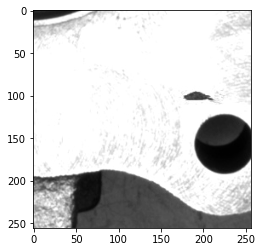

In [178]:
plt.imshow(np.squeeze(imgNOK[0], -1), cmap="gray")

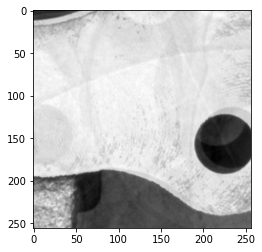

In [179]:
plt.imshow(np.squeeze(SISimg[0], -1), cmap="gray")